# Using matplotlib to visualize Stackdriver metrics for Bigtable

This tutorial demonstrates how to use the Python [matplotlib](https://matplotlib.org/) library to visualize Bigtable metrics with [Stackdriver Monitoring](https://cloud.google.com/monitoring/docs/). While you can visualize some metrics in the Bigtable console or in the Stackriver Monitoring console using `Metrics Explorer`, using `matplotlib` offers you the full flexibility and expressiveness of Python and the [pandas](http://pandas.pydata.org/) data science library and a powerful toolkit for designing custom graphs and figures.

`matplotlib` and `pandas` can be used with Stackdriver Monitoring with [Jupyter](http://jupyter.org/) notebooks, or with [Google Cloud Datalab](https://cloud.google.com/datalab/). Follow this link for [a more in-depth tutorial of the Stackdriver Monitoring pandas integration with Cloud Datalab.](https://github.com/googledatalab/notebooks/blob/master/tutorials/Stackdriver%20Monitoring/Getting%20started.ipynb).

## Dependencies

This notebook depends on `matplotlib`, `pandas`, and the [google-cloud-monitoring](https://github.com/GoogleCloudPlatform/google-cloud-python/tree/master/monitoring) Python client library. These are also listed in `requirements.txt`.

## Bigtable autoscaler

This tutorial demonstrates metrics obtained from running a Bigtable [loadtest](https://github.com/GoogleCloudPlatform/google-cloud-go/blob/master/bigtable/cmd/loadtest/loadtest.go), while also 
running the [Bigtable autoscaler sample](https://github.com/GoogleCloudPlatform/python-docs-samples/tree/master/bigtable/autoscaler). Notably, we plot several Bigtable metrics such as CPU load and bytes received, and examine how they change in response to a change in node counts.


In [3]:
%matplotlib inline
import datetime

from google.cloud import monitoring
import matplotlib.pyplot as plt

With our necessary libraries imported, we first gather the relevant metrics. In this case, a load test was performed for an hour that was finished on June 6, 2017. We query for several metrics that ended at that last hour, and convert them to pandas dataframes. To simply query for recent metrics, omit the `end_time` parameter.

One useful gotcha to note is that a mispelled metric name in the `query` call will result in a "a 403 - user does not have permission to see metric", which might mislead you into thinking there was an authentication error.

In [6]:
client = monitoring.Client()

# Replace this timestamp with one where you expect to see Bigtble metrics
end_time = datetime.datetime(year=2017, month=6, day=12, hour=23)

# Queries from end_time - 1 hour until end_time
# end_time defaults to now, so omit it to get recent metrics
node_count_query = client.query('bigtable.googleapis.com/cluster/node_count', end_time=end_time, hours=1)
cpu_query = client.query('bigtable.googleapis.com/cluster/cpu_load', end_time=end_time, hours=1)
received_bytes_query = client.query('bigtable.googleapis.com/server/received_bytes_count', end_time=end_time, hours=1)
latency_query = client.query('bigtable.googleapis.com/server/latencies', end_time=end_time, hours=1)

node_count_df = node_count_query.as_dataframe()
cpu_df = cpu_query.as_dataframe()

# Align the received bytes query along 5 minutes to reduce noise
received_bytes_query = received_bytes_query.align(monitoring.Aligner.ALIGN_MEAN, minutes=5)
received_bytes_df = received_bytes_query.as_dataframe()

With our data gathered, we can now plot it using `matplotlib`. In this case, we simply create multiple graphs on top of each other. Aligned vertically, we can see that as node count increased, metrics ilke average CPU usage decreased.

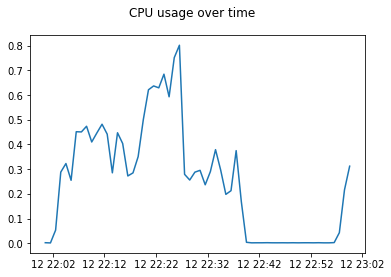

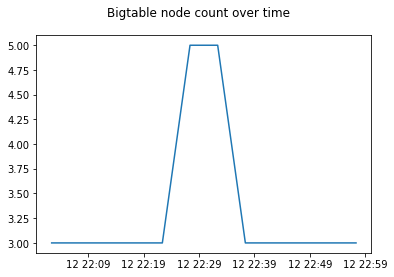

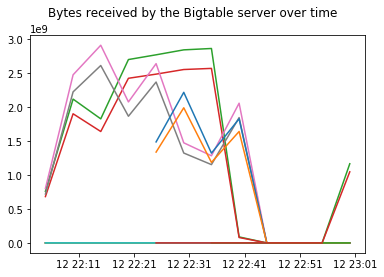

In [5]:
fig = plt.figure()
fig.suptitle('CPU usage over time')
plt.plot(cpu_df)

fig = plt.figure()
fig.suptitle('Bigtable node count over time')
plt.plot(node_count_df)
plt.show()

fig = plt.figure()
fig.suptitle('Bytes received by the Bigtable server over time')
plt.plot(received_bytes_df)
plt.show()